##Set up


In [68]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://drive.google.com/uc?export=download&id=h1XVeZoF7rvDbSS38_MML6Rm2GCnHQEFI0'
    !pip install category_encoders==2.*
    !pip install pdpbox
    #shap
    #dpdbox
    

# If you're working locally:
else:
    DATA_PATH = '../data/'

#import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from pdpbox.pdp import pdp_interact, pdp_interact_plot




#from google.colab import files
#from google.colab import drive
#drive.mount('drive', force_remount=True)

In [69]:
  #wrote a function to generate era names given a year
  def eracalc(year):
    if (year >= 1960) & (year <=1969):
       return '60s'

    elif (year >= 1970) & (year <=1979):
      return '70s'  

    elif (year >= 1980) & (year <=1989):
      return '80s'  

    elif (year >= 1990) & (year <=1999):
      return '90s' 

    else:
      return 'NA'   
 

## Wrangle Data


In [70]:
#Data Wrangle function:

def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['release_date'])

  #make new features
  df['month'] = df['release_date'].dt.month
  df['name_length'] = df['name'].str.len()

  #set release date as the index
  df.set_index('release_date', inplace=True)

  #using eracalc function build above
  df['era'] = df['year'].apply(eracalc)

  #Subset data to include from 1960-1999
  condition = (df['year'] >= 1960) & (df['year'] <= 1999)
  df = df[condition]
  
  #Sorting values by era and then by popularity
  df = df.sort_values(by=['era', 'popularity'], ascending=[True, False])
  
  #Subsetting df to include top 1000 songs in each era
  eras = df['era'].unique()
  df_new = pd.DataFrame()

  for era in eras:
     df_era = df[df['era'] == era]
     df_era = df_era.iloc[:2000, :]
     df_new = df_new.append(df_era)

   


  #Drop high cardinality & constant features
  df_new.drop(columns= ['artists', 'id', 'name', 'year'], inplace = True)

  #rearraging similar features to be together to improve readability
  # df = df[['artists', 'name', 'release_date', 'year', 'duration_ms', 'popularity',
  #         'valence', 'acousticness', 'danceability',
  #         'energy', 'instrumentalness', 'liveness', 'loudness',  
  #         'speechiness','tempo', 'key',
  #         'explicit', 'mode']]
  return df_new

df = wrangle('data.csv')



## EDA


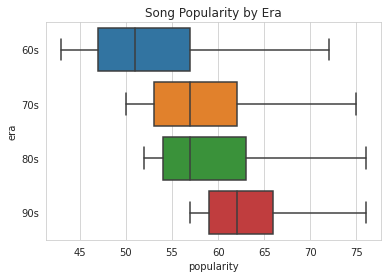

In [71]:
import seaborn as sns
sns.set_style('whitegrid')

ax1 = sns.boxplot(x="popularity", y="era", orient= 'h', data=df, showfliers=False).set_title('Song Popularity by Era')


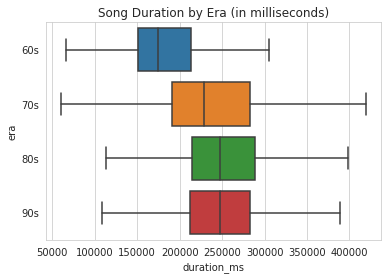

In [72]:
sns.set_style('whitegrid')

ax2 = sns.boxplot(x="duration_ms", y="era", orient= 'h', data=df, showfliers=False).set_title('Song Duration by Era (in milliseconds)')


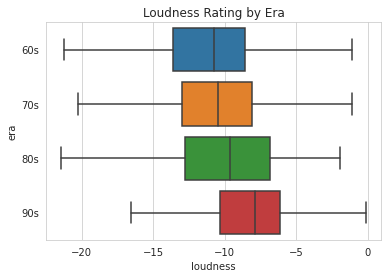

In [73]:
sns.set_style('whitegrid')

ax3 = sns.boxplot(x="loudness", y="era", orient= 'h', data=df, showfliers=False).set_title('Loudness Rating by Era')


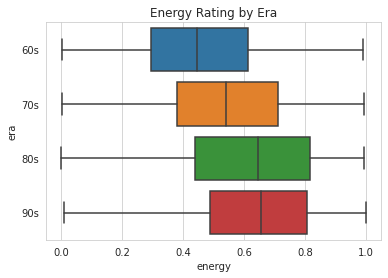

In [74]:
sns.set_style('whitegrid')

ax4 = sns.boxplot(x="energy", y="era", orient= 'h', data=df, showfliers=False).set_title('Energy Rating by Era')


## Split Data


In [75]:
#splitting into feature matrix and target vector
target = 'era'
X = df.drop(columns = target)
y = df[target]

In [76]:
#Train, test, val split, ask why use cutoff instead
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, train_size= 0.8, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, train_size= 0.8, random_state=42)



## Establish Baseline

In [77]:
#Establishing a baseline accuracy score based on highest value count instance
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline accurary:', baseline_acc)

Baseline accurary: 0.25390625


##Build Model

In [78]:
# 1. Logistic Regression
model_lr = make_pipeline(
          StandardScaler(),
          LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [79]:
# 3. Random Forest
model_rf = make_pipeline(
            RandomForestClassifier(random_state=42,
                                   n_jobs= -1)
)


model_rf.fit(X_train, y_train);

In [80]:
#4. XGB
model_xgb = make_pipeline(
              XGBClassifier(random_state=42,
                            n_jobs=-1)
)


model_xgb.fit(X_train, y_train);

##Check Metrics

In [81]:
#Comparing model accuracy

#Model_lr
print('Logistic Regression Model')
print('Training accuracy:', model_lr.score(X_train, y_train))
print('Validation accuracy:', model_lr.score(X_val, y_val), '\n')

#Model_rf
print('Random Forest Model')
print('Training accuracy:', model_rf.score(X_train, y_train))
print('Validation accuracy:', model_rf.score(X_val, y_val), '\n')

#Model_xgb
print('XGB Model')
print('Training accuracy:', model_xgb.score(X_train, y_train))
print('Validation accuracy:', model_xgb.score(X_val, y_val))

Logistic Regression Model
Training accuracy: 0.5154296875
Validation accuracy: 0.5046875 

Random Forest Model
Training accuracy: 1.0
Validation accuracy: 0.6125 

XGB Model
Training accuracy: 0.6953125
Validation accuracy: 0.60234375


In [82]:
#Generating classification reports for each model

print('Classification Reports \n')
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)), '\n\n')

print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)), '\n\n')

print('XGBClassifer')
print(classification_report(y_val, model_xgb.predict(X_val)), '\n')

Classification Reports 

Logistic Regression
              precision    recall  f1-score   support

         60s       0.63      0.70      0.66       328
         70s       0.37      0.30      0.33       321
         80s       0.43      0.40      0.41       317
         90s       0.55      0.61      0.58       314

    accuracy                           0.50      1280
   macro avg       0.49      0.50      0.50      1280
weighted avg       0.49      0.50      0.50      1280
 


Random Forest
              precision    recall  f1-score   support

         60s       0.74      0.74      0.74       328
         70s       0.50      0.50      0.50       321
         80s       0.57      0.48      0.52       317
         90s       0.62      0.73      0.67       314

    accuracy                           0.61      1280
   macro avg       0.61      0.61      0.61      1280
weighted avg       0.61      0.61      0.61      1280
 


XGBClassifer
              precision    recall  f1-score   suppor

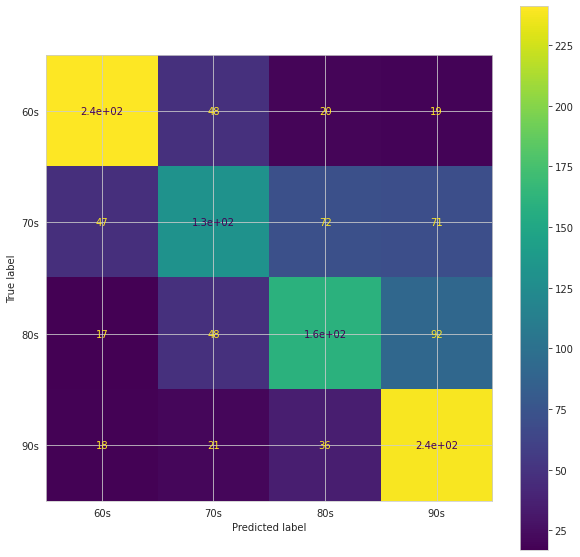

In [83]:
#Confusion Matrix
fig, ax = plt.subplots(figsize= (10,10))
plot_confusion_matrix(model_xgb, X_val, y_val, ax=ax);

##Tune Model

## Communicate Results

In [84]:
perm_imp = permutation_importance(
    model_xgb,
    X_val, # Always use your VALIDATION set
    y_val, 
    n_jobs=-1,
    random_state=42)

In [85]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

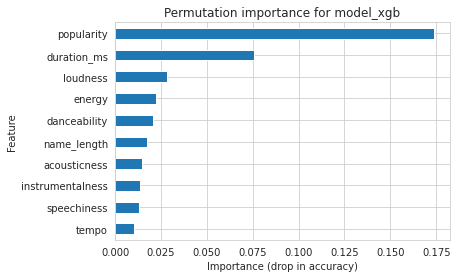

In [86]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

In [87]:
#Final Model Accuracy
print(classification_report(y_test, model_xgb.predict(X_test)))

              precision    recall  f1-score   support

         60s       0.79      0.77      0.78       425
         70s       0.53      0.43      0.47       379
         80s       0.57      0.47      0.52       397
         90s       0.59      0.81      0.68       399

    accuracy                           0.63      1600
   macro avg       0.62      0.62      0.61      1600
weighted avg       0.62      0.63      0.62      1600

